In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import math
import warnings

import os
try:
    os.mkdir('Plots')
    print('Created Plots directory')
except:
    print('Plots directory already exists')
    pass

Plots directory already exists


## Cs-137 Test Data Resolution as a function of Peaking and Gap Time

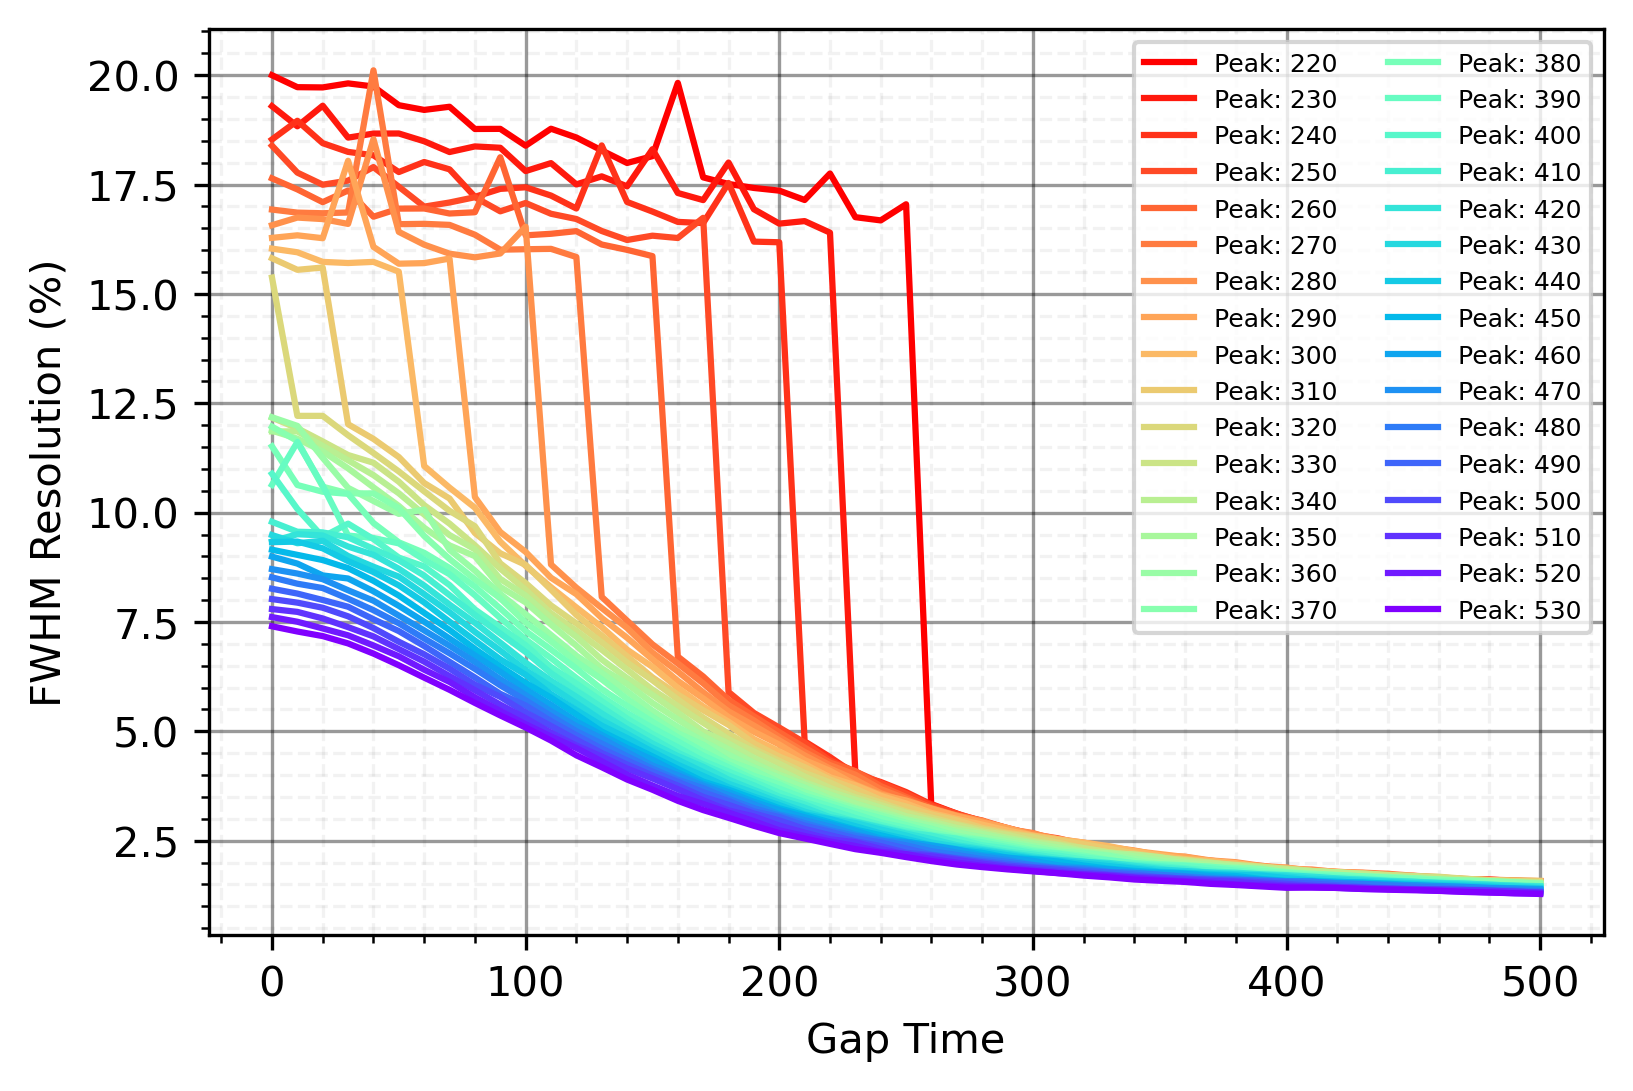

In [2]:
files = [[int(f.split('p')[1][:3]), 'Cs137-Test-Fits/Fits/'+f] for f in os.listdir('Cs137-Test-Fits/Fits/')]
files.sort()

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(1, 0, len(files)))

gs = list(range(0,510,10))

plt.figure(dpi=300)
for i, file in enumerate(files):
    gfr = np.load(file[1])
    
    resolutions = np.abs(((gfr[:,3]*2.35482)/gfr[:,2])*100)
    
    plt.plot(gs, resolutions, label='Peak: {}'.format(file[0]), color=colors[i])
plt.legend(fontsize=6, ncol=2)
plt.xlabel('Gap Time')
plt.ylabel('FWHM Resolution (%)')
plt.grid(which='major', color='k', linestyle='-', alpha=0.4)
plt.minorticks_on()
plt.grid(which='minor', color='k', linestyle='--', alpha=0.05)
plt.savefig('Plots/cs137_resolution_optimization.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Creation of Spectra

## Functions Used

In [3]:
def determine_rise(signal, sigma=8, window=20, offset=15):
    # Input filtered signal, returns index of start of rise on pulse
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    
    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))
    
    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)
    
    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if gn-gp < window and gn-gp > 0:
                close = True
        if not close:
            rise_start = gp
            break
    
    return int(rise_start-offset)

def delay_signal(signal, delay=2000, sample_size=500, seed=69):
    # Adds an artifcial delay on pulse to act like 3316 delay functionality
    np.random.seed(seed)
    noise_samp = signal[:sample_size]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    noise = np.random.normal(mean, 0.9*std, delay)
    return np.hstack([noise, signal])

def dkl(signal, i, k, l, w):
    """
    Calculates dkl value given a signal, 
        i = index of start of rise
        k = peaking time
        l = peaking time + gap time
        w = width of window to sample on pulse (trapezoid output width)
    """
    signal = delay_signal(signal, delay=w)
    vj = signal[i+w:i+w+w]
    vjk = signal[i-k+w:i+w+w-k]
    vjl = signal[i-l+w:i+w+w-l]
    vjkl = signal[i-k-l+w:i+w+w-k-l]
    return vj - vjk - vjl + vjkl
    
def s(signal, start_rise, tau, peaking_time, gap_time, w=0):
    """
    Input exponential signal, returns "trapezoid"
        start_rise = index of start of rise
        tau = decay constant of exponential (RC circuit related)
        peaking_time = "width" of rise of trapezoid
        gap_time = "width" of flat top of trapezoid
        w = width of trapezoid output width (default value calculated)
    """
    if w == 0:
        w = int(round(2.5*peaking_time+gap_time, 0))
    ss = []
    dkl_s = dkl(signal, start_rise, peaking_time, peaking_time+gap_time, w)
    for j in range(w):
        if j == 0:
            ss.append(0)
        else:
            ss.append(ss[j-1]*(1+1/tau)+ dkl_s[j])
    return np.array(ss)

def trapezoid(x, a, b, c, tau1, tau2):
    # Trapezoid signal shape
    y = np.zeros(len(x))
    c = -np.abs(c)
    a = np.abs(a)
    (tau1,tau2) = (min(tau1,tau2),max(tau1,tau2))
    y[:int(tau1)] =  a*x[:int(tau1)] + b
    y[int(tau1):int(tau2)] =  a*tau1 + b 
    y[int(tau2):] = c*(x[int(tau2):]-tau2) + (a*tau1 + b)
    return y

def trapezoid_height(trapezoid_signal, tau1=400, tau2=800):
    # Fits trapezoid signal and then returns the average height of the flat top
    popt, pcov = curve_fit(trapezoid, np.arange(len(trapezoid_signal)), trapezoid_signal, method = 'lm',
                      p0=[200, -8000, 200, tau1, tau2])
    trap_height = np.mean(trapezoid_signal[math.floor(popt[3]):math.ceil(popt[4])])
    return trap_height

def gauss(x, H, A, x0, sigma):
    # Gaussian signal shape
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    # Fits gaussian and returns fit parameters
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

def calibrate_energy(ch, a1, a2, a3, a4, a5, b):
    # Energy calibrate channel number given calibration constants
    return a1*ch + a2*ch**2 + a3*ch**3 + a4*ch**4 + a5*ch**5 + b

## Importing Data and Calibration constants

In [4]:
#f = h5py.File('Data/Test-928/Co57-4in-2min.h5')
f = h5py.File('Data/Test-928/Co60-36in-2min.h5')
#f = h5py.File('Data/Test-928/Cs137-24in-2min.h5')
#f = h5py.File('Data/Test-928/Th228-24in-20min.h5')

data = np.array(f['raw_data'])
f.close()
        
calib_consts = np.load('calibration_fit.npy')

print("There are a total of {} pulses in this dataset".format(len(data)))

There are a total of 20263 pulses in this dataset


## Looping through pulses and shaping, fitting and calculating pulse height

In [5]:
peak, gap = 530, 500
max_height = 519300 # Calculated for peak = 530, gap = 500

energies = []

warnings.filterwarnings("ignore")
for i, pulse in enumerate(tqdm(data, desc="Creating spectra")):
    fs = savgol_filter(pulse, 51, 0)
    try:
        trap_height = trapezoid_height(s(fs, determine_rise(fs), 15000, peak, gap))
    except:
        print('Index {} failed to fit trapezoid'.format(i))
        continue
        
    if not math.isnan(trap_height):
        if trap_height < max_height:
            energies.append(calibrate_energy(trap_height, *calib_consts))
energies = np.array(energies)

Creating spectra:   0%|          | 0/20263 [00:00<?, ?it/s]

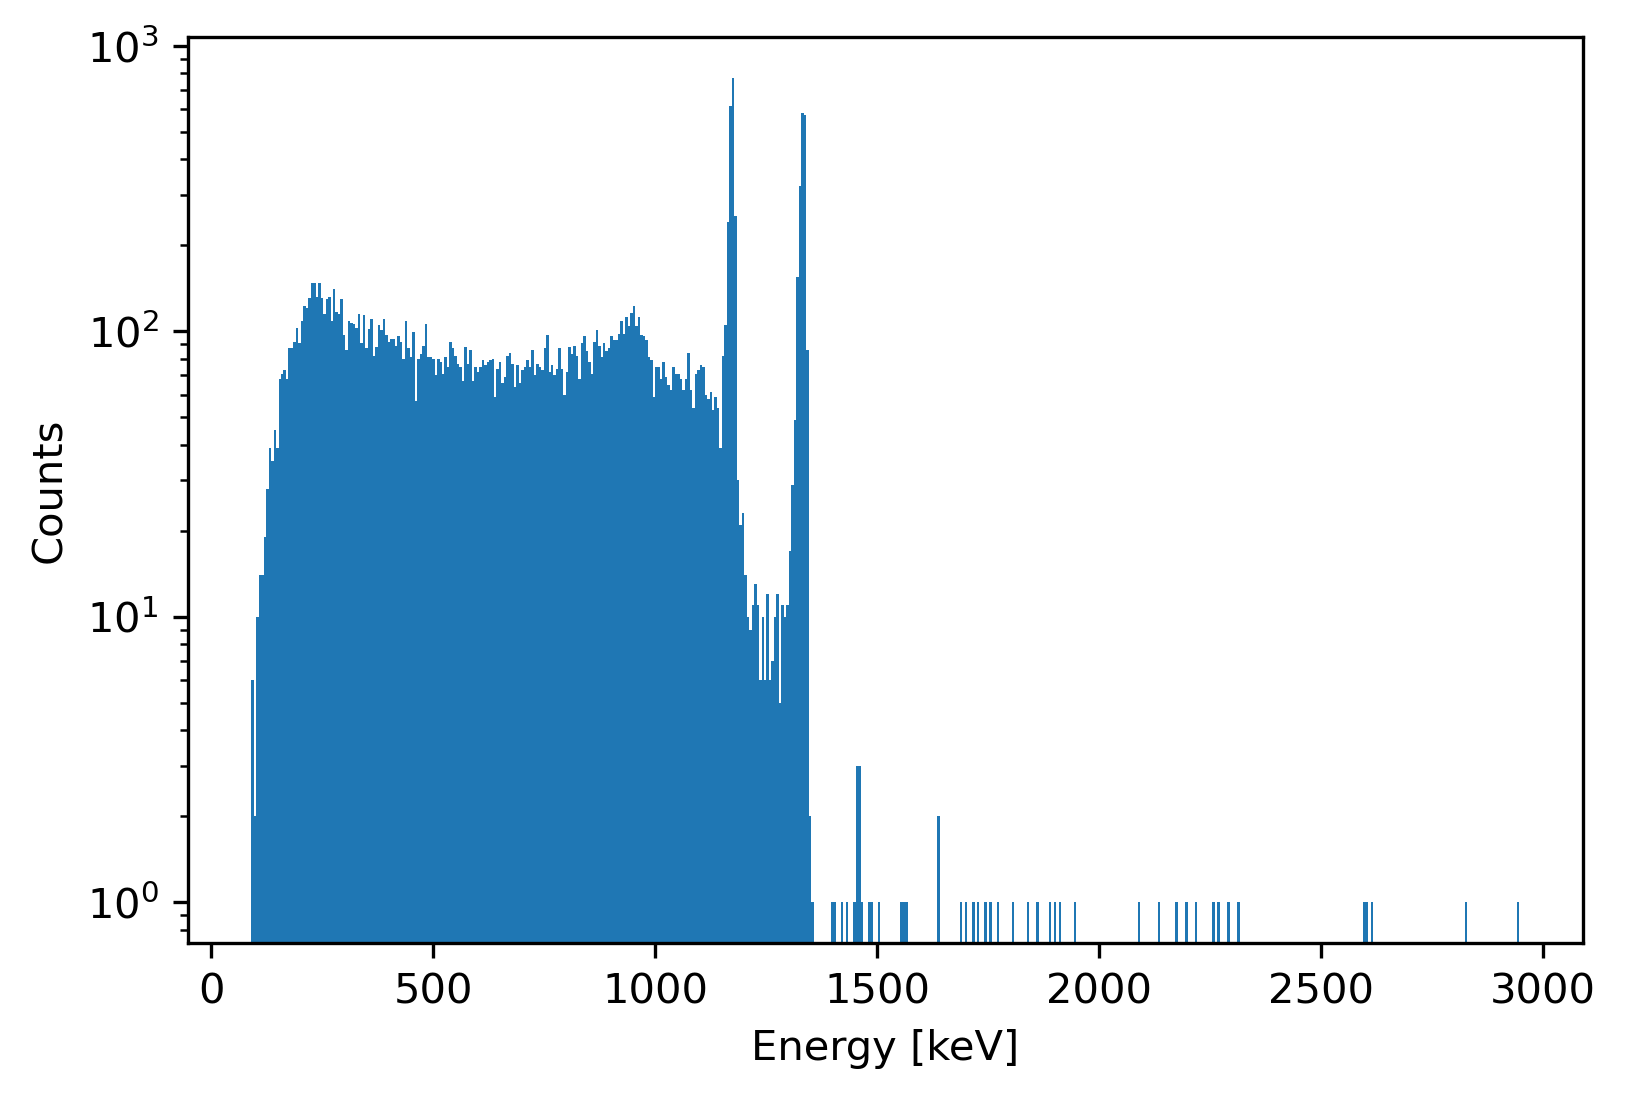

In [6]:
plt.figure(dpi=300)
counts, bins_out, patches = plt.hist(energies, bins=2**9)
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
plt.semilogy()
plt.show()